# Midterm 1

A data set x, with a structure dimension of 30 and a sampling dimension of 120 has been
placed in the array test2.nc in the Canvas files menu under “Mid Term 1 data”. I also
provide there a Notebook fragment to read the data. You are to do EOF analysis of this and
determine whether there are any significant structures. Here are the required steps.
Annotate all your plots with titles, legends, xlabels and ylabels. (60pts)

In [1]:
import os
from statistics import mode

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import xarray as xr
import xskillscore as xs
import matplotlib.colors as colors 
from scipy.optimize import curve_fit
from scipy.stats import gamma, kurtosis, linregress, norm, ranksums, skew
from scipy.stats import ttest_ind as ttest
from tabulate import tabulate

In [2]:
df = xr.open_dataset("/glade/work/zespinosa/Courses/Objective_Analysis/midterm/test2.nc")
# df = (df - df.mean(["time"]))/df.std(["time"])
df

<xarray.Dataset>
Dimensions:  (time: 120, space: 30)
Coordinates:
  * time     (time) timedelta64[ns] 1 days 2 days 3 days ... 119 days 120 days
  * space    (space) float32 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0 29.0
Data variables:
    value    (time, space) float64 ...

### 1. Make a Hovmöller plot of the data. Structure is abscissa and sampling is ordinate. You can think of the structure dimension as space and the sampling dimension as time, if you like. Include a color bar. Make the aspect ratio 1-2 so that the sampling dimension is stretched out relative to the structure dimension (pbaspect in Matlab, ax.set_aspect in Matplotlib).


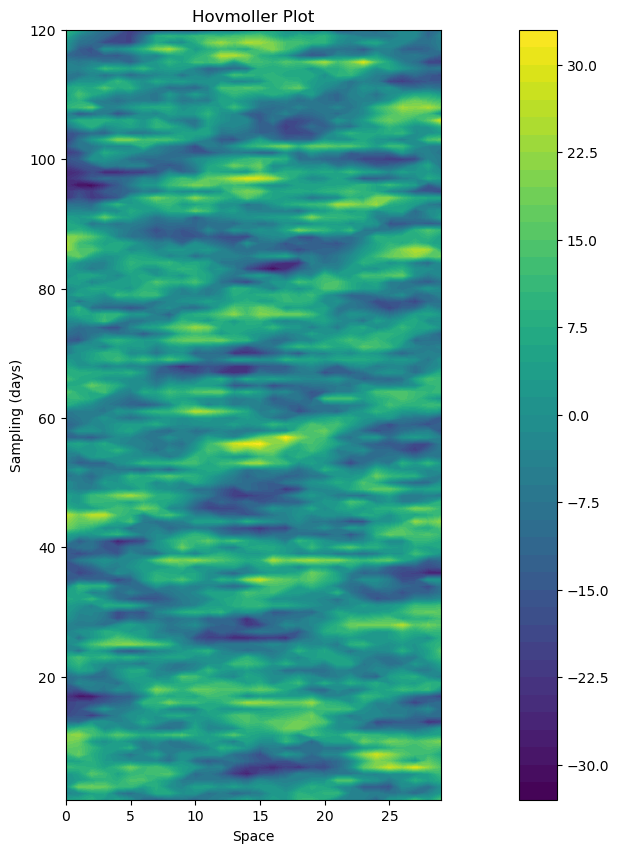

In [3]:
fig = plt.figure(figsize=[20, 10])
ax = plt.subplot(1, 1, 1)
img = ax.contourf(df.space, np.arange(1, 121, 1), df.value, 50)
ax.set_aspect(.5)
ax.set_ylabel("Sampling (days)")
ax.set_xlabel("Space")
ax.set_title("Hovmoller Plot")
fig.colorbar(img, ax=ax)

### 2. Plot the eigenvalue spectrum with North uncertainty bars in units of fraction of explained variance. How many significant eigenvectors are there, according to the raw North criterion?

In [4]:
def autocorrelation(df, dim, step, grand=False):
    df_shifted = df.copy()
    df_shifted = df_shifted.shift(time=step)
    a1 = xr.corr(df_shifted, df, dim=dim) # autocorrelation
    
    if grand: 
        ga1 = a1.mean() # grand autocorrelation (Ask Dennis what to do here)
        
        return a1, ga1
    
    return a1

def get_dof(df):
    """
    Get degrees of freedom using Bretherton '99 Quadratic Formula
    N* = N(1 - a1^2)/(1 + a1^2)
    """
    ntime, nspace = df.shape
    a1, ga1 = autocorrelation(df, dim='time', step=1, grand=True)
    nstime = ntime*(1 - ga1**2)/(1 + ga1**2)
    
    # Round to nearest integer number
    nstime = np.around(nstime, 0)
    
    return nstime.values

There are 86.0 degrees of freedom (N*/N = 0.7166666666666667)
Variability explained by first 5 EOFs= [0.3550325  0.1533485  0.11518608 0.09399364 0.06916379]


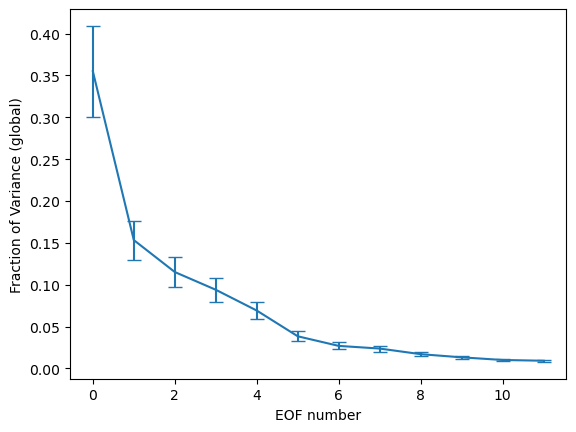

In [67]:
def explore_data():
    # Lets begin by looking at the timeseries at each location to see if there are significant trends
    for i, v in enumerate(df.space):
        ci = df.value[:, i]
        mu = np.around(np.mean(ci), 2)
        plt.plot(ci, label=f"{i}, {mu}")

    plt.xlabel("time")
    plt.ylabel("space")

    
def plot_eigenvalue_spectrum(spectrum, yerror):
    """
    My values differ slightly from those generated by Dennis
    """
    index = np.linspace(0,24,25)
    plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
    plt.ylabel('Fraction of Variance (global)')
    plt.xlabel('EOF number')
    plt.show()
    
    
def get_eigenvalue_spectrum(df):
    # First get degrees of freedom
    dof = get_dof(df) 
    print(f"There are {dof} degrees of freedom (N*/N = {dof/120})")

    # Second Computer Eigenvalue Spectrum
    u, s, vh = np.linalg.svd(df.T)
    spectrum = s*s.T
    spectrum = spectrum/sum(spectrum)
    print("Variability explained by first 5 EOFs=", spectrum[:5])
    yerror = spectrum*np.sqrt(2/dof)
    
    # Third Plot Eigenvalue Spectrum
    plot_eigenvalue_spectrum(spectrum, yerror)
    
    return u, s, vh

u, s, vh = get_eigenvalue_spectrum(df.value)

### 3. Make a plot of the first five eigenvectors, where the abscissa is the structure dimension. Make sure the reader can tell which EOF is which.

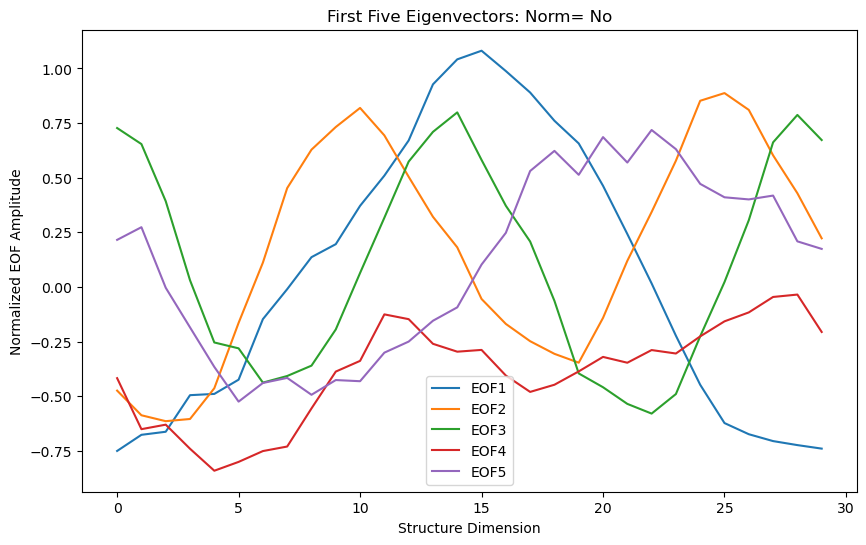

In [68]:
neig = 5
for i in range(neig):
    # Here we scale the eigenvector according to the amplitude in the dataset that it represents.
    d = u.T[i,:]*np.sqrt(s[i]/30)
    # Next, plot
    plt.plot(d, label=f"EOF{i+1}")
plt.title("First Five Eigenvectors: Norm= No")
plt.ylabel("Normalized EOF Amplitude")
plt.xlabel("Structure Dimension")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 6)

### 4. Plot the principal components of the first four eigenvectors, where the abscissa is the sampling dimension. Make sure the reader can tell which PC is which.

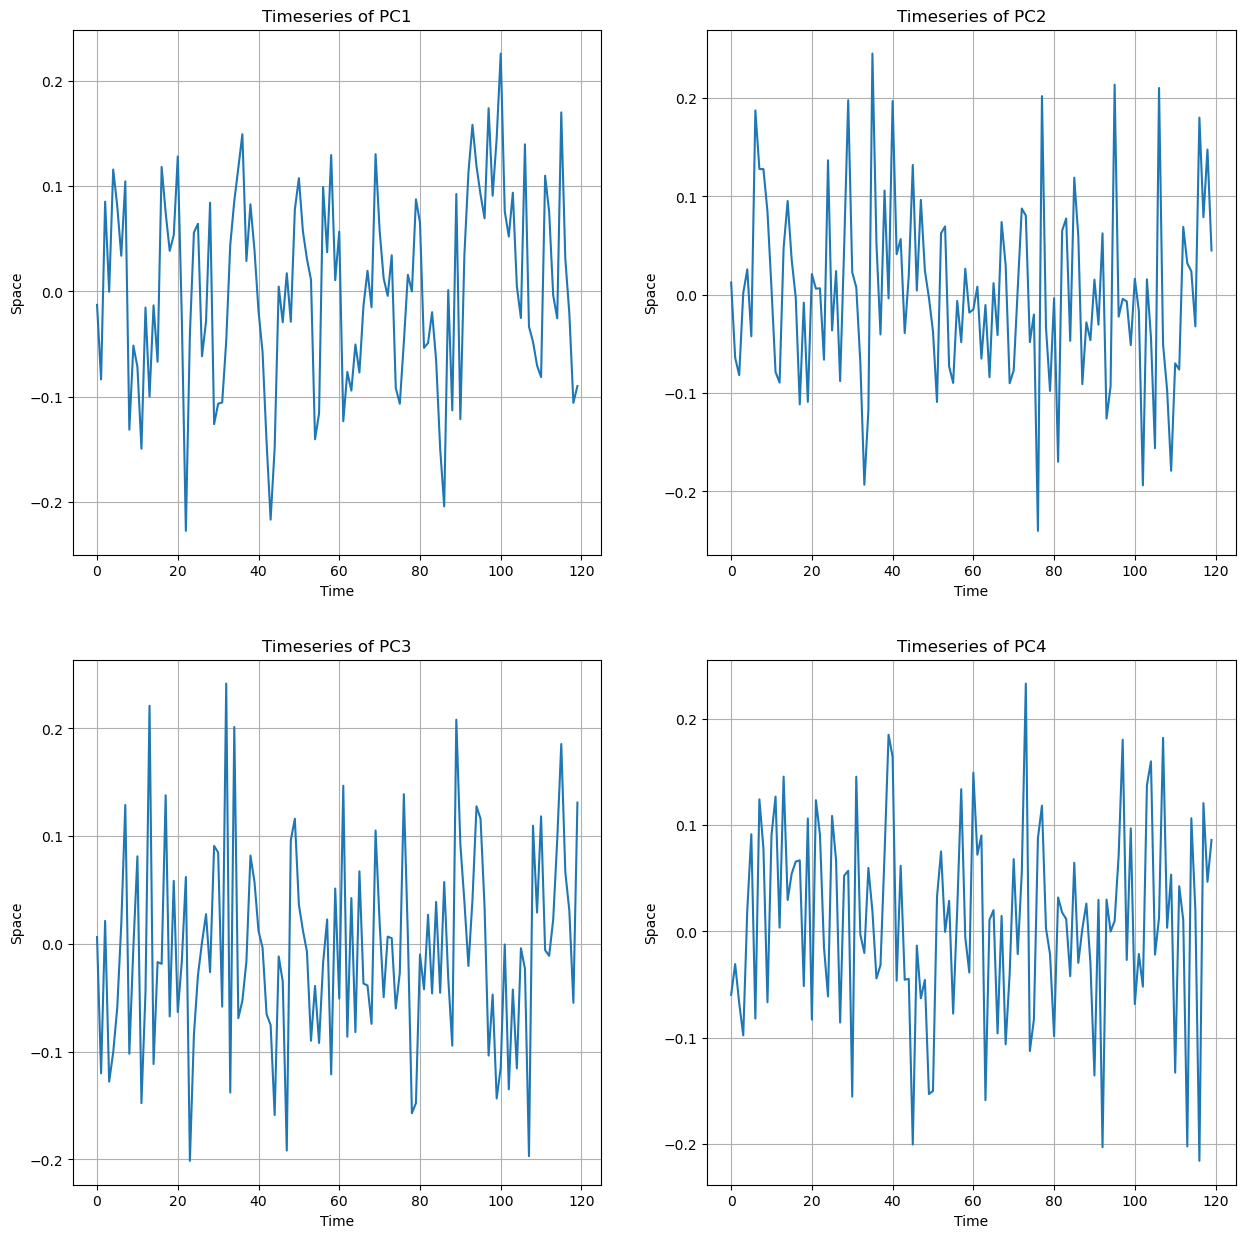

In [69]:
# Plot time series of first four eigenvectors 
fig, axs = plt.subplots(2,2)
fig.set_size_inches(15, 15)
for i, ax in enumerate(axs.flatten()):
    ts = vh[:,i]
    ax.plot(np.arange(120), ts.T)
    ax.set_title(f'Timeseries of PC{i+1}')
    ax.grid()
    ax.set_xlabel("Time")
    ax.set_ylabel("Space")

### 5. Plot the regressions of the first five normalized principal component time series onto the unormalized data. These would be the D vectors or the regression maps. Make sure the reader can tell which regression corresponds to which EOF.

In [70]:
# smat = np.zeros((30, 120))
# smat[:30, :30] = np.diag(s)
# z = np.matmul(smat, vh).shape
# lam = np.linalg.inv(np.sqrt(np.diag(s)))
# smat[:30, :30] = lam
# D = np.matmul(df.value.values, np.matmul(smat, vh))/120
# plt.plot(D.T[:,0])

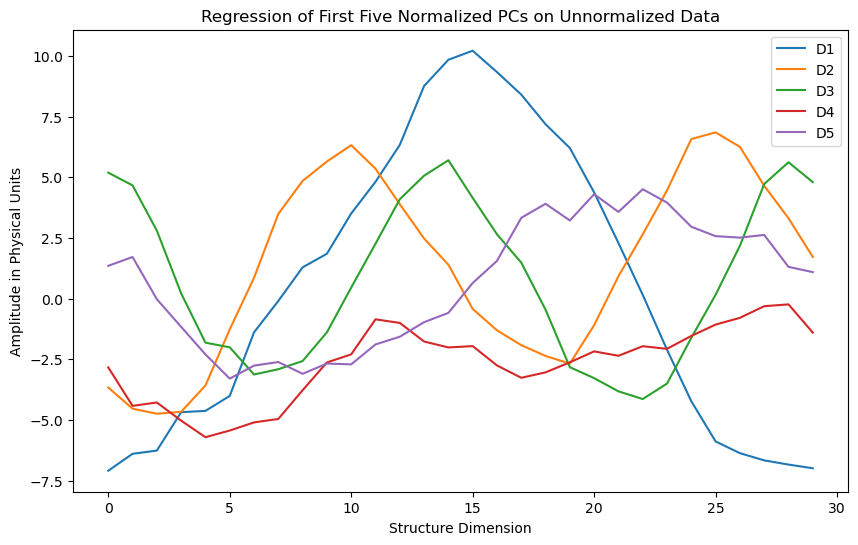

In [71]:
def calc_regressions(
    df, # Original data frame
    pcs, # Principal components matrix
    num_regs=3, # Number of regressions to plot
    plot_func=True # Function to use for plotting 
):
    for i in range(num_regs):
        # Get first PC and standardize
        t = pcs[i,:]/np.std(pcs[i,:])
        # Regress first PC onto original data and divide by number samples
        reg = np.matmul(t, df.to_numpy()) / t.shape[0]
        plt.plot(reg, label=f"D{i+1}")
    
    plt.title("Regression of First Five Normalized PCs on Unnormalized Data")
    plt.ylabel("Amplitude in Physical Units")
    plt.xlabel("Structure Dimension")
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    

calc_regressions(
    df=df.value, 
    pcs=vh, 
    num_regs=5, 
    plot_func=True 
)

### 6. Discuss on the basis of all this evidence what structures you have identified with this analysis that appear to be plausible ‘physical’ structures that you would study further. Explain your reasoning.

Based on the analysis that I have conducted here, even though we have found one eigenvalue that explains ~35% of the variability and is significant according to the North test, I am hesitant to conclude that it represents a real physical mode of variability. Before concluding this, I would want to examine the one-point correlation map and rotate the eigenvectors using an orthogonal Varimax criterion. The principle reason that I am cautious of these results is that the first, second, third, and fifth EOFs look like sine waves with various wavelengths, periods, and phases spanning structure domain. The fourth EOF looks like roughly flat, suggesting some type of correlation across the spatial domain, that we do not clearly observe in the Hovmoller diagram. Together these five EOFs capture roughly 78% of the variability. Additionally, examining the timeseries of the first four principle components, we do not observe any obviously interesting structure. I believe we are likely analyzing pure red noise or red noise with a superimposed oscillation. For this reason, I would would be unlikely to further study these structures. 